# Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
from pickle import dump
import scipy as sp
from sklearn.preprocessing import StandardScaler, LabelEncoder
import statsmodels.api as sm
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

from useful_functions import *  # our own set of functions

# Downloading Data   

In [2]:
df = yf.download('AAPL', start='2012-02-01',  end='2024-01-07').drop(['Adj Close'], axis=1)

[*********************100%%**********************]  1 of 1 completed


Calculating log returns and historical volatility.

In [3]:
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
df['Reailized_Volatility'] = df['Close'].pct_change().rolling(window = 21).std(ddof = 0)*np.sqrt(252) # Historically Realized Volatility with 21 days
df['Returns'] = df['Close'].pct_change()

Analysing the log returns' distribution.

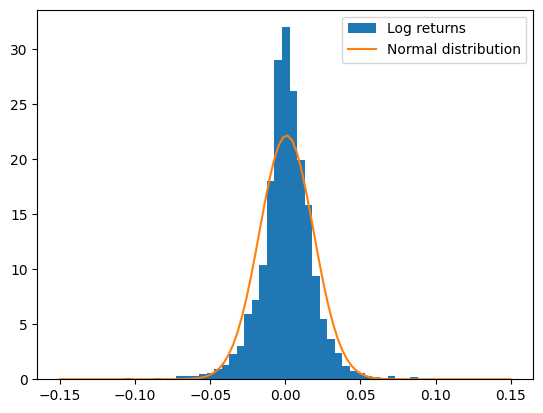

In [4]:
fig, ax = plt.subplots()

x = np.linspace(-0.15, 0.15, 100)
y = sp.stats.norm.pdf(x=x, loc=df['Log_Returns'].mean(), scale=df['Log_Returns'].std())

ax.hist(df['Log_Returns'], bins=50, density=True, label='Log returns')
ax.plot(x, y, label='Normal distribution')

ax.legend()

plt.show()

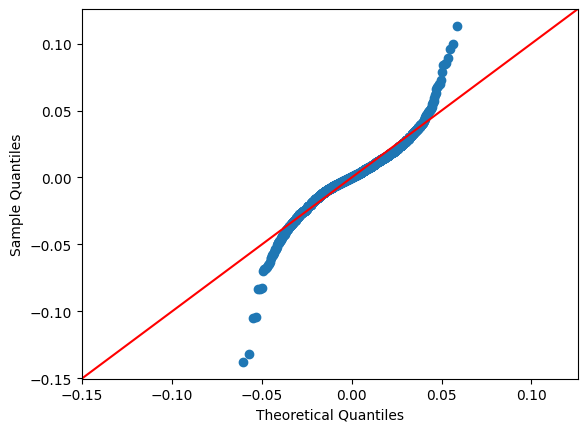

In [5]:
fig, ax = plt.subplots()

sm.qqplot(df['Log_Returns'], line='45', loc=df['Log_Returns'].mean(), scale=df['Log_Returns'].std(), ax=ax)

plt.show()

We can see that AAPL log-returns are not normally distributed. Their distribution's tails are much fatter.

# Feature engineering

## Signal (label)

We are doing classification problem to predict whether the returns will go up (positive log returns), down (negative log returns) or won't change significantly (log returns in range $[-a, b]$). We are going to use these predictions in simulated alghorytmic trading strategy. To decide what does insignificant change mean we need to think how are we going to interpret such signals.

If the signal is 'up' we buy the stock if we do not have it or do nothing when we have it.\
If the signal is 'down' we sell the stock if we have it or do nothing when we do not have it.\
If the signal is 'same' we do nothing.

Because in real world there are transaction costs, it is not optimal to make transactions when the predicted change is very small. To infer the value of interval $[-a, b]$ we are going to use transactional costs. We assume they are equal to 0.1% of the transaction value, therefore it does not make sense to make a transaction when absolute change in returns is less than 0.1%. Because we use log returns we need to convert this value to log return.

In [6]:
np.log(0.999)


-0.0010005003335835344

In [7]:
np.log(1.001)

0.0009995003330834232

Therefore $[a,b]=[-0.001,0.001]$

$
Signal_t = 
\begin{cases}
up \quad if \quad log\_returns_{t+1} > 0.001 \\
same \quad if \quad log\_returns_{t+1} \in [-0.001, 0.001] \\
down \quad if \quad log\_returns_{t+1} < -0.001 \\
\end{cases} $

In [8]:
df['Signal'] = np.nan

for i in range(len(df['Log_Returns'])):
    if df['Log_Returns'][i] > 0.001: 
        df['Signal'][i] = 'up'
    if df['Log_Returns'][i] < -0.001: 
        df['Signal'][i] = 'down'
    if (df['Log_Returns'][i] >= -0.001 and df['Log_Returns'][i] <= 0.001):
        df['Signal'][i] = 'same'

## Technical Indicators

We decided to use following technical indicators:
- Moving averages:
    - SMA (Simple Moving Average) with 14 days window size,
    - EMA (Exponential Moving Average) with 14 days window size,
    - HMA (Hull mMoving Average) with 14 days window size,
- Momentum indicators:
    - MACD (Moving Average Convergence / Divergence, basic line),
    - RSI (Relative Strength Index) with 14 days window size,
    - Stochastic Oscillator (baic line),
    - ADX (Trend Strength Indicator, basic line).


In [9]:
# Moving Averages
for i in [14]:
    df['SMA_' + str(i)] = ta.sma(df['Close'], length=i)
    df['EMA_' + str(i)] = ta.ema(df['Close'], length=i)
    df['HMA_' + str(i)] = ta.hma(df['Close'], length=i)

# Momentum Indicators
df['MACD'] = ta.macd(df['Close']).iloc[:, 0] # basic line
df['RSI'] = ta.rsi(df['Close'], length=14)
df['Stoch_Osc'] = ta.stoch(close=df['Close'], high=df['High'], low=df['Low']).iloc[:, 0] # basic line
df['ADX'] = ta.adx(close=df['Close'], high=df['High'], low=df['Low']).iloc[:, 0] # basic line

## Other features

We also use following features caclulated using open, close, high and low prices and volume:
- Difference between open and close prices relative to open price,
- Difference between low and high prices relative to low price,
- Percentage change in volume.

In [10]:
df['Open-Close'] = (df['Open'] - df['Close'])/df['Open']
df['High-Low'] = (df['High']-df['Low'])/df['Low']
df['Volume-pct-change'] = df['Volume'].pct_change()

After performing multiple hyperparameter tunnings using Grid Search, we noticed that some input features are influencing negatively on the performance of the model. Therefore, we decided to remove them.

In [11]:
df = df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'HMA_14', 'SMA_14', 'ADX', 'Stoch_Osc'], axis=1)

Now we can trim our dataframe to the desired time range (2013-2023).

In [12]:
start = '2013-01-01'
end = '2023-12-31'

df = df[start:end]

Now, we create our dataset. For our $X$ we use data lagged by $1, 2, 3, ..., lag$ days (see deatils in `useful_functions.py`). For $Y$ we use signal.

In [13]:
X = df.drop(['Signal'], axis=1)
Y = df[['Signal']]

lag = 14
data_X, data_Y = create_dataset(X, Y, lag)

We also scale and encode our data.

In [14]:
Scaler_X = StandardScaler()
Scaler_Y = LabelEncoder()

In [15]:
Scaled_Data_X = Scaler_X.fit_transform(data_X)
Scaled_Data_Y = Scaler_Y.fit_transform(data_Y)
stock_returns = df['Returns'][lag:]

Now, we pickle our dataset and scalers to use it later.

In [16]:
np.save('input/Scaled_Data_X', Scaled_Data_X)
np.save('input/Scaled_Data_Y', Scaled_Data_Y)
stock_returns.to_pickle('input/stock_returns.pkl')
df.to_pickle('input/df.pkl')
dump(lag, open('input/lag.pkl', 'wb'))

In [17]:
dump(Scaler_X, open('data_objects/Scaler_X.pkl', 'wb'))
dump(Scaler_Y, open('data_objects/Scaler_Y.pkl', 'wb'))

In [18]:
Scaled_Data_Y

array([2, 0, 0, ..., 1, 2, 0])

# Exploratory data analysis

In [19]:
df['Signal'].value_counts()

Signal
up      1367
down    1213
same     188
Name: count, dtype: int64

We can see that numbers of up and downs is relatively similar, while number of 'same' is much lower.

For the rest of our EDA, we will use `ydata_profiling` library.

In [19]:
from ydata_profiling import ProfileReport

In [21]:
prof = ProfileReport(df)

In [22]:
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]